#### CPU usage analysis during LLM inference

Due to exponential growth in LLM use cases, inference has become widely popular. ChatGPT, an application of generative LLM, is now the world's 8th most popular website. The model inference is costly, primarily due to expensive GPU accelerators. Modern LLMs contain billions of hyperparameters, typically requiring several GPU accelerators to load into the memory. Due to that, the cloud is the preferred infrastructure for deploying LLM inference platforms. 

Additionally, demand for LLMs has led to a global GPU capacity crunch. Due to that, cloud service providers (CSPs) employ efficient resource management techniques to serve LLMs at scale. This includes techniques to improve throughput at the node, such as request batching, iterative scheduling, model and pipeline parallelism. Moreover, the inference is accelerated across the nodes using direct memory access techniques via high-speed links, such as InfiniBand connections. Collectively, the LLM inference workflow is complex. Although the model calculation is done via GPU accelerators, such complex workflows emphasize the role of CPUs in facilitation.

The rise of AI clusters due to LLM popularity has challenged the net-zero carbon efforts of CSPs. In this context, it is crucial to scale for inference sustainably. Recent works have shed light on AI clusters and shown that GPUs dominate operational carbon footprint in inference clusters, and CPUs dominate embodied carbon footprint. Furthermore, the operational carbon footprint significantly decreases upon integrating green energy sources. Therefore, a critical challenge to solve is the embodied carbon footprint of CPUs. Once acquired, the embodied carbon of hardware platforms needs to be amortized over time. Therefore, the solution requires techniques for prolonged usage of CPUs. Data shows that over the years, the performance improvements of CPU generations are minor. The reason to upgrade CPUs is the reliability concerns of usage over its rated lifetime. Recent works show that aging CPUs can incur unpredictable reliability issues. In this context, the goal of this work is to derive a technique that can reduce the risks of CPU reliability. 

Recent investigations into CPU usage of applications shed light on how uneven usage of CPU cores can lead to premature CPU aging. In hyper-scale clouds, machines with faulty cores are isolated and replaced. The solution is to even out core usage, reducing the risks of core failures. Authors explore multiple OS-level applications, such as TCP and virtualization threads, but not inference clusters. Recent works in inference clusters show that machines can cater to workloads with fewer cores. We intend to investigate uneven core usage in the inference clusters and leverage the opportunity to use excess available CPU cores to derive a technique to even it out.

To draw motivations, we first investigate the case of uneven core usage in inference clusters. We use a high-fidelity LLM cluster simulator developed by Microsoft Research, which replays real production inference request traces that employ splits, a state-of-the-art LLM inference framework. We extend the simulator to model the CPU. In the testbed, each physical machine runs an instance of the inference application. We model each instance task as a separate process run by the CPU. Each new process is run on a separate CPU core to model worst-case CPU utilization. We assume CPU core utilization from the overhead of the guest and host OS is minimal. We develop a probabilistic model based on the CPU task allocation on an AI server and employ that in the simulator to mimic the realistic operation of the operating system in task allocation for CPU cores while running typical loads of an AI server. We implement an energy model based on the CPU idle states. We implement the Linux menu governer's core idle state govern algorithm. Our testbed contains 26 DGX-A100 machines and 25 DGX-H100 machines and runs a splitwise framework with iterative scheduling. The CPU tasks we model include each iteration, instance notification of the link data transfer and task submission upon request's arrival. We replay traces with multiple request rates. We observe application metrics of TTFT, TBT, and response time (to quantify the impact of the application) and CPU usage metrics of worst-time-to-failure (WTTF) of CPU cores, CPU energy, and number of parallel tasks run by the CPU.

In [3]:
from matplotlib.ticker import MultipleLocator
from matplotlib import pyplot as plt

import pandas as pd

#path = '/Users/tharindu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/phd-student/projects/dynamic-affinity/simulations/parsed_data.csv'
path = '/Users/tharindu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/phd-student/projects/dynamic-affinity/debug/parsed_data.csv'
df = pd.read_csv(path)

code_df = df[df['kind'] == 'code']
conv_df = df[df['kind'] == 'conv']

plt.rcParams.update({'font.size': 11})


def plot_metrics(df, title):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
    #fig.tight_layout(pad=5.0)

    cols = ['technique', 'rate',
            'ttft_times_p90', 'tbt_times_p90', 'response_times_p90',
            'core_wttf_cv_p90', 'core_health_cv_p90', 'cluster_energy_j', 'cpu_tasks_throughput_p90'
            #, 'cpu_tasks_throughput_max'
            ]

    col_names = {
        'ttft_times_p90': 'p90 TTFT',
        'tbt_times_p90': 'p90 TBT',
        'response_times_p90': 'p90 E2E',
        'core_wttf_cv_p90': 'p90 WTTF CV',
        'core_health_cv_p90': 'p90 Core Health CV',
        'cluster_energy_j': 'p90 Energy(J)',
        'cpu_tasks_throughput_p90': 'p90 Tasks Count',
    }

    df = df[cols]
    df = df[df['rate'] <= 150]

    # Plot each metric as a separate subplot
    plot_count = 0
    for i, col in enumerate(df.columns[2:]):
        plot_count += 1
        subplot_df = df[['rate', 'technique', col]]
        subplot_df.set_index('rate', inplace=True)
        subplot_df = subplot_df.sort_values(by='rate')
        row = int(i / 4)
        current_ax = axs[row][i % 4]
        for technique, group in subplot_df.groupby('technique'):
            is_cpu_metric = row > 0
            group.plot(y=col, ax=current_ax, grid=True, marker='o', markersize=7, markeredgewidth=4)
            current_ax.set_ylabel(col_names[col])
            current_ax.set_xlabel('Request Rate (req/s)')
            current_ax.legend('')
            current_ax.set_xlim(left=24)
            current_ax.xaxis.set_major_locator(MultipleLocator(10))
    

    plt.tight_layout()
    #plt.title(title)
    plt.show()


Observe the cluster for the coding trace

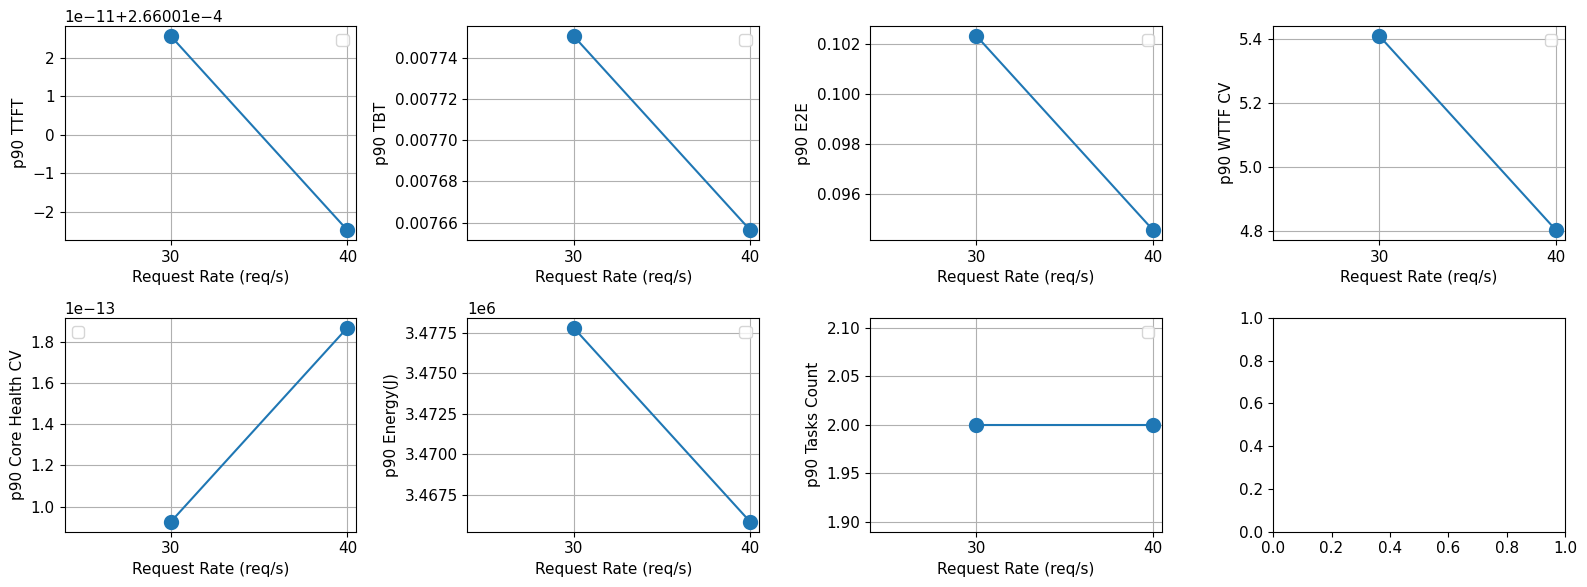

In [4]:
plot_metrics(df=code_df, title="Code trace")

Observer the cluster for the conversation trace

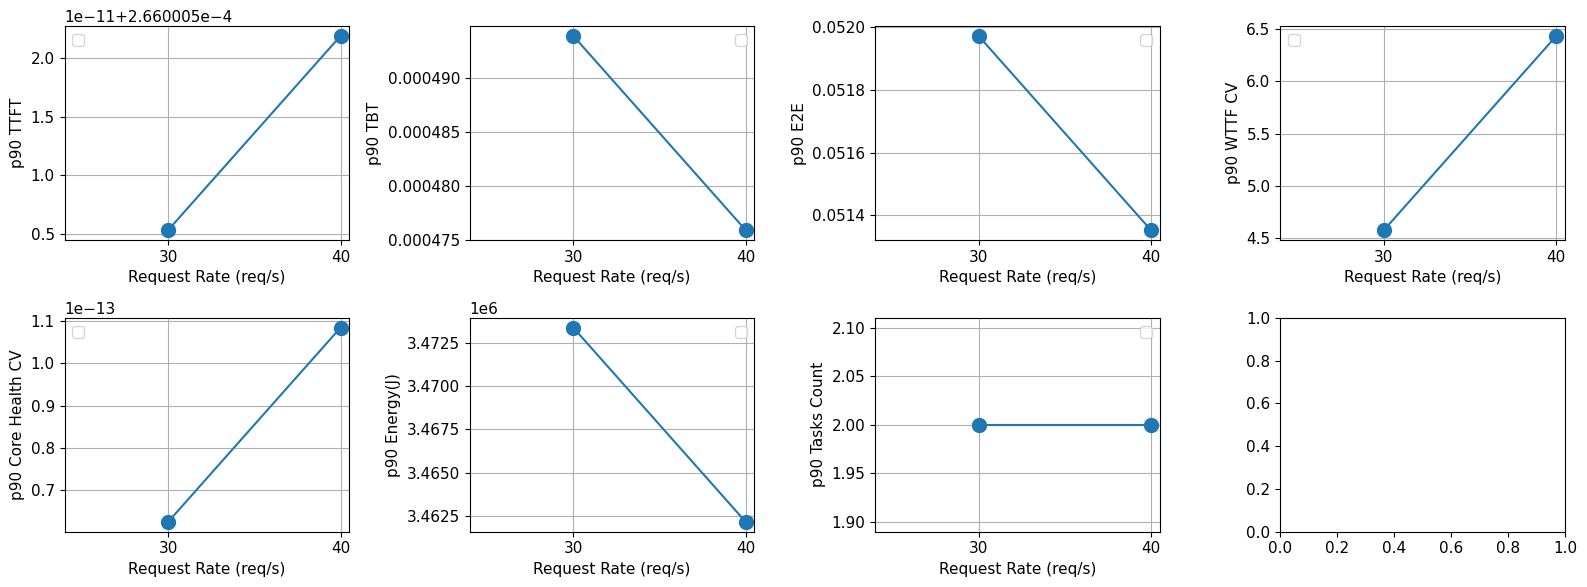

In [5]:
plot_metrics(df=conv_df, title="Conv trace")
#plot_metrics(df=conv_df)

p90 task count plot indicate number of parallel tasks running on a machine rises with the request rate. Also, it shows that the upper limit of that is significantly lesser than the total number of cores in the cpu. A100 and H100 both machines have cpu cores over 100, yet the cores required stays around 20. Note that our allocation policy run tasks in individual cores (worst allocation scenario). 

p90 worst time to failure (WTTF) plot shows that the coefficient of variation for WTTF per machine is almost always above 1, indicating a high variation of WTTF.

Collectively, plots shows that cores are unevenly used during llm inference, and also we have the opportunity to operate at lesser number of cores (verifies the findings shows by the other works - hotcarbon'24). Controlled management of physical cpu cores that can be allocated to tasks, to even-out core usage across the cpu, is then possible. In LLM inference, the size of the request does not matter to the cpu core, because token size related processing is taken over by the GPU accelerate. The role of the cpu is facilitating inference process. For example, for an inference task that takes 1 second to process, the core energy consumption do not change regardless of the token size of the request associated to the task. Yet, the time takes for a request could change with token size, given how long GPU take to process the request. 

The goal of the research is to reduce the p90 cv of the WTTF, such that the CPU aging rate is reduced. Given that, CSP can continue using the CPU beyond rated life, and still upgrade GPUs to keep up with the technology improvements of GPU.

#### Proposing solution

Approach,

- Step 01: Reduce number of cores being used: instance resize to match request rate
    - pick a minimum number of cores initially that suits: N
    - define a delta, such that instance vcores can be N +- delta
    - [done] resize instance has an overhead cost. can we use the instance in-between? need to model this: 
        - done: 0.035414 seconds (ref: Zhao, S., Li, M., Yan, M., & Lin, Z. (2024). Ditto: Elastic Confidential VMs with Secure and Dynamic CPU Scaling. arXiv preprint arXiv:2409.15542). 
    - if sufficient cores are not present, tasks are going to time slice across available cores. such time slicing has a cost and probably a function of the number of extra tasks. need to model this.
        -  model: number of over-commited tasks.
    - algo: decrease cores one by one as long as time slicing does not occur. if detect an increase, and stay that state for some time. aggressiveness of that and the staying time should be tunable parameters (i.e. our approach is reactive, rather than being predictive). 
- Step 02: Conduct dynamic affinity to even-out usage: dynamic affinity to even-out
    - at the node, vcore affinity is dynamically moved. when to move? that is also a critical problem. we can blindly do it based on time interval and let the management process to sleep in-between, yielding minimum overhead. Also can monitor physical core utilization and move. need to model and implement this.
        -   Approach 01: time-based heuristic. get current number of cores of the vm. compare with total cores. determine the time gap, and shift affinity.
        -   Approach 02: observe physical core utilization and shift accordingly.

Combined 1 & 2 will yield lower WTTF CV (even-out). Expenses are the resize overhead and over-commit overhead.

Baseline is the standard splitwise